# Power Spectrum Host Detection Example Notebook

In this notebook, we will use the functions available from the powerspectrum.py file to check for the presence of hosts in a series of images. First, we will check for hosts in simulated images, where a host is known to be present (or not present). Then, we will test with an example stamp from ZTF data.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.stats import multivariate_normal, wasserstein_distance
from astropy.visualization import simple_norm
import pandas as pd

os.chdir('/media3/hayes/crp7_hostless/py/')
import powerspectrum as ps
os.chdir('/media/emille/git/COIN/CRP7/hostless/code/')

#plt.style.use('/media3/hayes/sami-emission-line-database/ipynb/stylesheet/sami.mplstyle')

In [2]:
import matplotlib

colors={"orange":"#ED9145",
        "dark_brown":"#473832",
        "beige":"#E2D3C1",
        "rose":"#BC7E74",
        "dark_blue":"#21609D",
        "light_blue":"#5C92C1",
        "dark_gray":"#4D5966",
        "black":"#27242A",
        "light_gray":"#8999A1",
        "golden_brown":"#87581D"}

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [colors['dark_blue'],
                                                                colors['orange']])

## Test on Simulated Data
First, check values of the KS test (or Anderson-Darling test) for when there is no host

In [4]:
def simulate_data(amp, size, show_plots=False):
    """
    """
    background = np.random.normal(0, 1, size=(size, size))

    x, y = np.meshgrid(np.arange(0, size, 1), np.arange(0, size, 1))
    pos = np.dstack((x, y))
    mvn = multivariate_normal(mean=[31, 31], cov=[[30.0, 5.], [8., 18.5]])
    host = (amp)**2 * mvn.pdf(pos)

    data = background + host

    if show_plots:
        fig, ax = plt.subplots(1, 3, figsize=(12,3))

        noise_im = ax[0].imshow(background, vmin=-4, vmax=4, 
                                cmap=cmap)
        ax[0].set_title('Pure Noise')
        fig.colorbar(noise_im)

        host_im = ax[1].imshow(host, vmin=0, vmax=4, cmap=cmap)
        ax[1].set_title('Simulated Host')
        fig.colorbar(host_im)

        data_im = ax[2].imshow(data, vmin=-4, vmax=4, cmap=cmap)
        ax[2].set_title('With Injected Host')
        fig.colorbar(data_im)
        plt.show()
        plt.clf()

    return background, host, data

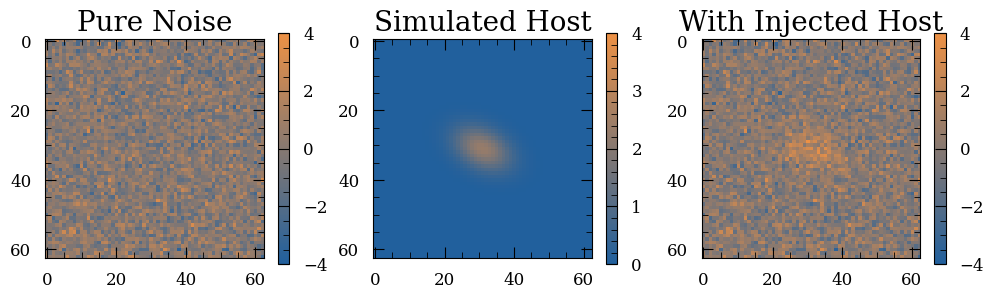

<Figure size 640x480 with 0 Axes>

In [39]:
# Simulate image of size im_size x im_size with NO host (amp = 0)
amp = 18
im_size = 63
background, host, data = simulate_data(amp, im_size, show_plots=True)

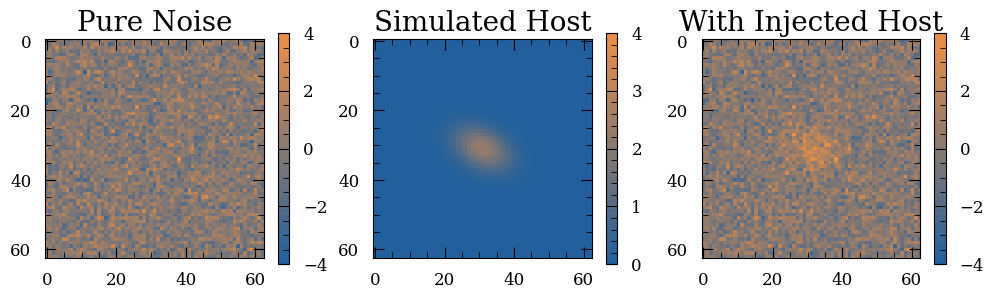

<Figure size 640x480 with 0 Axes>

In [18]:
_, _, tpl_data = simulate_data(amp, im_size, show_plots=True)

real_Abins_dict, shuffled_Abins_dict = ps.detect_host_with_powerspectrum(tpl_image=tpl_data, 
                                                                         metric='kstest', N_iter=200)

N_iter = 200
size = 29

WD_dist_real_to_shuffled = []
WD_dist_shuffled_to_shuffled = []

for n in range(N_iter):

    iter1 = shuffled_Abins_dict[size][n]
    wd = wasserstein_distance(iter1, real_Abins_dict[size])
    WD_dist_real_to_shuffled.append(wd)

    for m in range(N_iter):
        if m >= n:
            continue
        
        iter2 = shuffled_Abins_dict[size][m]
        wd = wasserstein_distance(iter1, iter2)
        WD_dist_shuffled_to_shuffled.append(wd)

WD_dist_real_to_shuffled = np.array(WD_dist_real_to_shuffled)
WD_dist_shuffled_to_shuffled = np.array(WD_dist_shuffled_to_shuffled)

In [19]:
WD_dist_shuffled_to_shuffled.shape

(19900,)

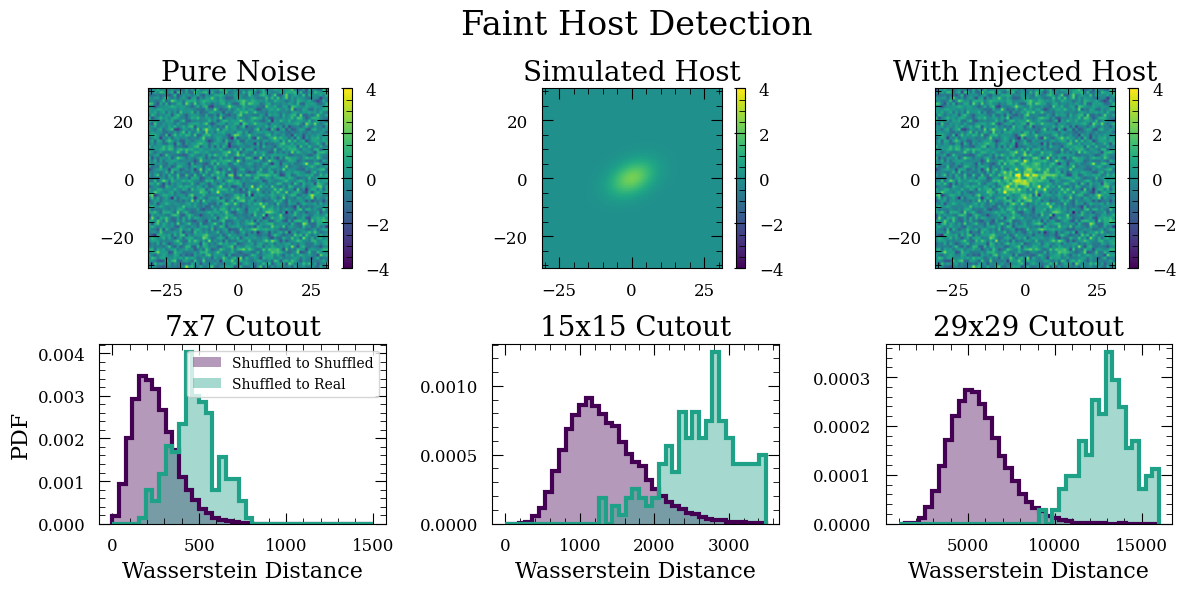

<Figure size 640x480 with 0 Axes>

In [15]:
background, host, data = simulate_data(amp, im_size, show_plots=False)

fig, ax = plt.subplots(2, 3, figsize=(12, 6))

noise_im = ax[0,0].imshow(background, origin='lower', extent=[-31, 31, -31, 31], vmin=-4, vmax=4)
ax[0,0].set_title('Pure Noise')
fig.colorbar(noise_im)

host_im = ax[0,1].imshow(host, origin='lower', extent=[-31, 31, -31, 31], vmin=-4, vmax=4)
ax[0,1].set_title('Simulated Host')
fig.colorbar(host_im)

data_im = ax[0,2].imshow(data, origin='lower', extent=[-31, 31, -31, 31], vmin=-4, vmax=4)
ax[0,2].set_title('With Injected Host')
fig.colorbar(data_im)

bins_list = [np.linspace(0, 1_500, 40), np.linspace(0, 3_500, 40), np.linspace(1_000, 16_000, 40)]
for s, size in enumerate([7, 15, 29]):

    real_Abins_dict, shuffled_Abins_dict = ps.detect_host_with_powerspectrum(tpl_image=data, metric='kstest', N_iter=200)

    N_iter = 200
    bins = bins_list[s]

    WD_dist_real_to_shuffled = []
    WD_dist_shuffled_to_shuffled = []

    for n in range(N_iter):

        iter1 = shuffled_Abins_dict[size][n]
        wd = wasserstein_distance(iter1, real_Abins_dict[size])
        WD_dist_real_to_shuffled.append(wd)

        for m in range(N_iter):
            if m >= n:
                continue

            iter2 = shuffled_Abins_dict[size][m]
            wd = wasserstein_distance(iter1, iter2)
            WD_dist_shuffled_to_shuffled.append(wd)

    WD_dist_real_to_shuffled = np.array(WD_dist_real_to_shuffled)
    WD_dist_shuffled_to_shuffled = np.array(WD_dist_shuffled_to_shuffled)
    
    ax[1,s].hist(WD_dist_shuffled_to_shuffled, bins, color='#440154', alpha=0.4, density=True, label='Shuffled to Shuffled');
    ax[1,s].hist(WD_dist_shuffled_to_shuffled, bins, color='#440154', histtype='step', lw=3, density=True);

    ax[1,s].hist(WD_dist_real_to_shuffled, bins, color='#1fa187', alpha=0.4, density=True, label='Shuffled to Real');
    ax[1,s].hist(WD_dist_real_to_shuffled, bins, color='#1fa187', histtype='step', lw=3, density=True);
    ax[1,s].set_title(f"{size}x{size} Cutout")
    ax[1,s].set_xlabel('Wasserstein Distance')

ax[1,0].legend()
ax[1,0].set_ylabel('PDF')

fig.suptitle('Faint Host Detection', fontsize=24, x=0.535)
fig.tight_layout()
plt.savefig('powerspec.pdf')
plt.show()
plt.clf()

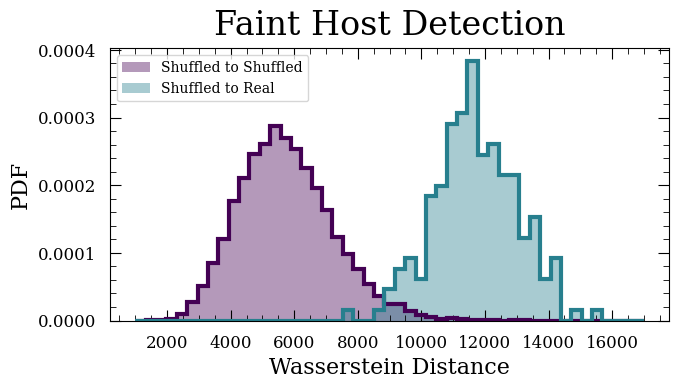

<Figure size 640x480 with 0 Axes>

In [24]:
bins = np.linspace(1_000, 17_000, 50)
fig, ax = plt.subplots(1,1, figsize=(7, 4))

ax.hist(WD_dist_shuffled_to_shuffled, bins, color='#440154', alpha=0.4, density=True, label='Shuffled to Shuffled');
ax.hist(WD_dist_shuffled_to_shuffled, bins, color='#440154', histtype='step', lw=3, density=True);

ax.hist(WD_dist_real_to_shuffled, bins, color='#277f8e', alpha=0.4, density=True, label='Shuffled to Real');
ax.hist(WD_dist_real_to_shuffled, bins, color='#277f8e', histtype='step', lw=3, density=True);

ax.set_xlabel('Wasserstein Distance')
ax.set_ylabel('PDF')
ax.set_title('Faint Host Detection', fontsize=24, y=1.02)
ax.legend()
fig.tight_layout()
plt.show()
plt.clf()

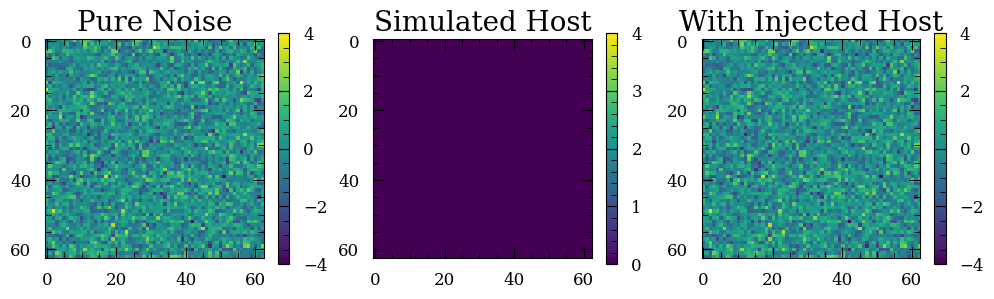

<Figure size 640x480 with 0 Axes>

In [73]:
# Simulate image of size im_size x im_size with NO host (amp = 0)
amp = 0
im_size = 63
_, _, tpl_data = simulate_data(amp, im_size, show_plots=True)

In [5]:
output_table = ps.detect_host_with_powerspectrum(tpl_image=tpl_data, metric='kstest', N_iter=200)

In [6]:
# Print the output table
## Notice the p-value, which we will take as our null result, as we know there is not a host in this case
output_table

IMAGE_TYPE,CUTOUT_SIZE,STATISTIC,PVALUE
str8,int64,float64,float64
TEMPLATE,7,0.09655778894472361,0.04656187268923195
TEMPLATE,15,0.27153266331658293,2.1826781103095693e-13
TEMPLATE,29,0.10613065326633164,0.021398332300803496


Now, check values of the KS test (or Anderson-Darling test) for when there is a host.

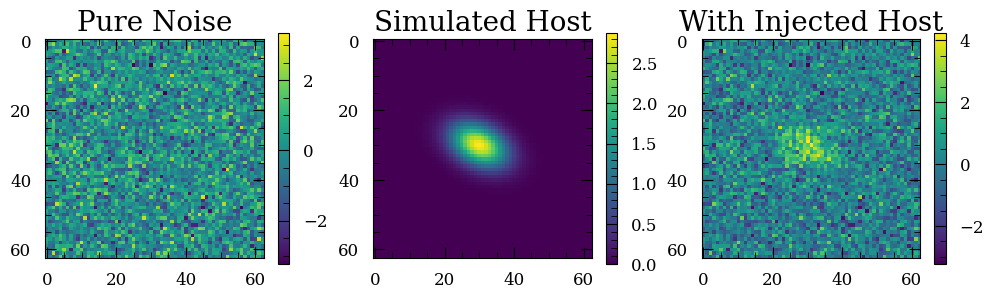

<Figure size 640x480 with 0 Axes>

In [7]:
# Simulate image of size im_size x im_size with a host of specified amplitude
amp = 20
im_size = 63
_, _, tpl_data = simulate_data(amp, im_size, show_plots=True)

In [9]:
# Run the power spectrum test on the simulated image
## I input the simulated data as "template" image, but in the simulated data case it doesn't matter.
## You could also input as the "science" image (sci_image).
output_table = ps.detect_host_with_powerspectrum(tpl_image=tpl_data, metric='kstest', N_iter=200)

In [10]:
# Print the output table
## Notice that the p-value indicates that 
output_table

IMAGE_TYPE,CUTOUT_SIZE,STATISTIC,PVALUE
str8,int64,float64,float64
TEMPLATE,7,0.16467336683417083,3.6822830941249335e-05
TEMPLATE,15,0.5525376884422111,2.4202773132978852e-57
TEMPLATE,29,0.9998994974874372,0.0


## Test on Real Data

In [3]:
objectID = 'ZTF18aajwbhh'

# Load in the science image and the associated segmentation mask from SExtractor
sci_seg = fits.open(f'/media3/CRP7/hosts/data/EXTRAGALACTIC/sexoutput/{objectID}_SCI_0145_SEG.fits')
sci_image = fits.open(f'/media3/CRP7/hosts/data/EXTRAGALACTIC/sexoutput/{objectID}_SCI_0145.fits')

# Load in the template image and the associated segmentation mask from SExtractor
temp_seg = fits.open(f'/media3/CRP7/hosts/data/EXTRAGALACTIC/sexoutput/{objectID}_TEMP_0145_SEG.fits')
temp_image = fits.open(f'/media3/CRP7/hosts/data/EXTRAGALACTIC/sexoutput/{objectID}_TEMP_0145.fits')

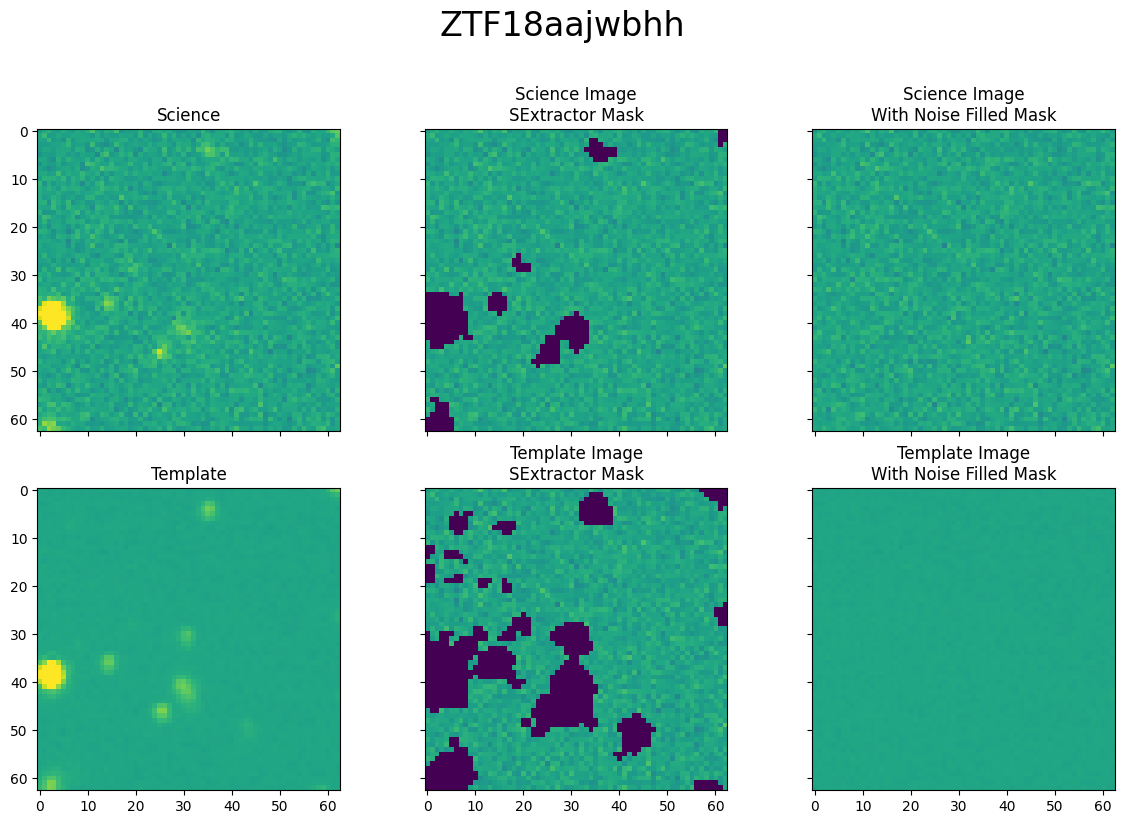

In [4]:
# Create subplots to show all 
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
fig.suptitle(objectID, fontsize=24, y=1.02)

# Show the science image
ax[0,0].imshow(sci_image[0].data, vmin=0, vmax=300)
ax[0,0].set_title('Science')

# Show the SExtractor mask for the science image
mask = sci_seg[0].data == 0
ax[0,1].imshow(np.where(mask, sci_image[0].data, -9999), vmin=0, vmax=300)
ax[0,1].set_title('Science Image\nSExtractor Mask')

# Show the masked science image with the masked locations filled with random noise
mask = sci_seg[0].data > 0
for_filling = np.random.normal(np.median(sci_image[0].data[~mask]), np.std(sci_image[0].data[~mask]), (63, 63))
for_filling = np.where(mask, for_filling, 0)
to_fill = np.where(mask, 0, sci_image[0].data)
sci_data = to_fill + for_filling
ax[0,2].imshow(sci_data, vmin=0, vmax=300)
ax[0,2].set_title('Science Image\nWith Noise Filled Mask')


# Show the template image
ax[1,0].imshow(temp_image[0].data, vmin=0, vmax=300)
ax[1,0].set_title('Template')

# Show the SExtractor mask for the template image
mask = temp_seg[0].data == 0
ax[1,1].imshow(np.where(mask, sci_image[0].data, -9999), vmin=0, vmax=300)
ax[1,1].set_title('Template Image\nSExtractor Mask')

# Show the masked template image with the masked locations filled with random noise
mask = temp_seg[0].data > 0
for_filling = np.random.normal(np.median(temp_image[0].data[~mask]), np.std(temp_image[0].data[~mask]), (63, 63))
for_filling = np.where(mask, for_filling, 0)
to_fill = np.where(mask, 0, temp_image[0].data)
tpl_data = to_fill + for_filling
ax[1,2].imshow(tpl_data, vmin=0, vmax=300)
ax[1,2].set_title('Template Image\nWith Noise Filled Mask')

fig.tight_layout()
fig.show()

In [5]:
# Run the power spectrum test on the science image and the template image
output_table = ps.detect_host_with_powerspectrum(sci_image=sci_data, 
                                                 tpl_image=tpl_data, metric='kstest', N_iter=200)

In [6]:
# Print the output table
## There does not appear to be a host, as the template has a (relatively) large p-value when looking at the 29x29 cutout, indicating that the
## distribution of real to shuffled distances is (relatively) highly consistent with the distribution of shuffled to shuffled images, which
## we know are are just noise.
output_table[0]

{7: array([52350.20337724, 52229.39405781, 98893.77031012]),
 15: array([ 365500.78151006,  604008.33830808,  515369.11440993,
         893913.87961511,  770043.151586  ,  880506.55480732,
        1084420.83714393]),
 29: array([  576581.45557189,  2187467.89978037,  4550571.11461376,
         2479291.80574996,  2837838.70075353,  4430616.45358004,
         8278420.09052711,  4171656.19488002,  5456427.80001733,
         8562301.31617335,  8171198.79371502, 10557951.98563386,
        12971217.22809359,  9021436.40006199])}

In [7]:
### Emille

In [7]:
real_Abins_dict, shuffled_Abins_dict = \
           ps.detect_host_with_powerspectrum(tpl_image=temp_image[0].data, 
                                             metric='kstest', N_iter=1000)


N_iter = 1000
size = 7

WD_dist_real_to_shuffled = []
WD_dist_shuffled_to_shuffled = []

for n in range(N_iter):

    iter1 = shuffled_Abins_dict[size][n]
    wd = wasserstein_distance(iter1, real_Abins_dict[size])
    WD_dist_real_to_shuffled.append(wd)

    for m in range(N_iter):
        if m >= n:
            continue
        
        iter2 = shuffled_Abins_dict[size][m]
        wd = wasserstein_distance(iter1, iter2)
        WD_dist_shuffled_to_shuffled.append(wd)

WD_dist_real_to_shuffled = np.array(WD_dist_real_to_shuffled)
WD_dist_shuffled_to_shuffled = np.array(WD_dist_shuffled_to_shuffled)

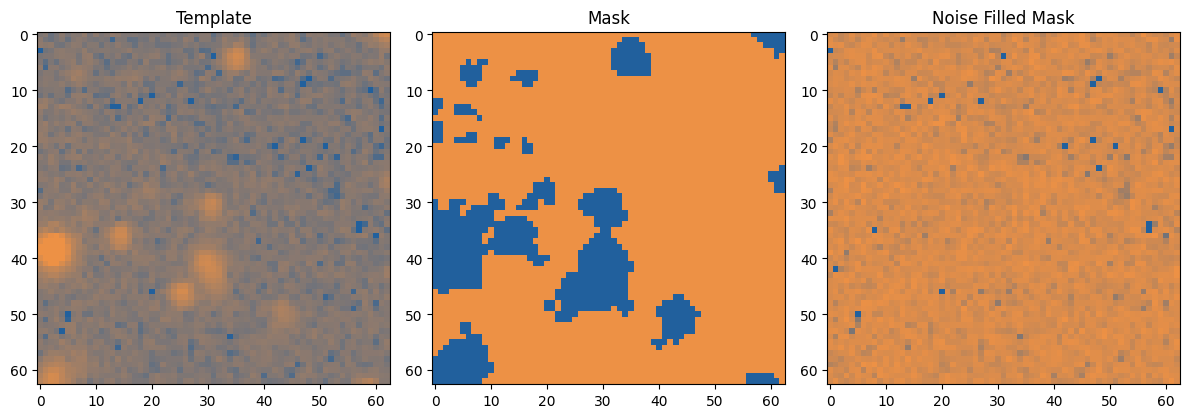

In [100]:
bins=np.logspace(np.log10(min(WD_dist_shuffled_to_shuffled)),
                 np.log10(max(WD_dist_shuffled_to_shuffled)), 50)

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create subplots to show all 
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
#fig.suptitle(objectID, fontsize=24, y=0.775)

# Show the template image
norm0 = simple_norm(temp_image[0].data, 'log', percent=99.)
ax[0].imshow(temp_image[0].data, norm=norm0, cmap=cmap)
ax[0].set_title('Template')

# Show the SExtractor mask for the template image
mask = temp_seg[0].data == 0
norm1 = simple_norm(np.where(mask, temp_image[0].data, -9999), 'log', percent=99.)
ax[1].imshow(np.where(mask, temp_image[0].data, -9999), norm=norm1, cmap=cmap)
ax[1].set_title('Mask')

# Show the masked template image with the masked locations filled with random noise
mask = temp_seg[0].data > 0
for_filling = np.random.normal(np.median(temp_image[0].data[~mask]), np.std(temp_image[0].data[~mask]), (63, 63))
for_filling = np.where(mask, for_filling, 0)
to_fill = np.where(mask, 0, temp_image[0].data)
tpl_data = to_fill + for_filling

norm2 = simple_norm(tpl_data, 'log', percent=99.)
ax[2].imshow(tpl_data, norm=norm2,  
             cmap=cmap)
ax[2].set_title('Noise Filled Mask')

fig.tight_layout()
fig.savefig('ZTF18aajwbhh_stamps.pdf', bbox_inches='tight')

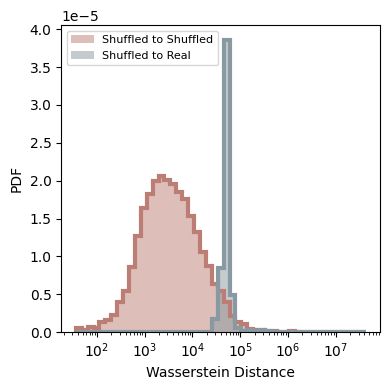

In [101]:
#bins = np.linspace(min(WD_dist_shuffled_to_shuffled), max(WD_dist_shuffled_to_shuffled), 50)
bins=np.logspace(np.log10(min(WD_dist_shuffled_to_shuffled)),
                 np.log10(max(WD_dist_shuffled_to_shuffled)), 50)

fig, ax = plt.subplots(1,1, figsize=(4, 4))

ax.hist(WD_dist_shuffled_to_shuffled, bins, color=colors['rose'], alpha=0.5, density=True, 
        label='Shuffled to Shuffled');
ax.hist(WD_dist_shuffled_to_shuffled, bins, color=colors['rose'], histtype='step', lw=3, density=True);

ax.hist(WD_dist_real_to_shuffled, bins, color=colors['light_gray'], alpha=0.5, density=True, 
        label='Shuffled to Real');
ax.hist(WD_dist_real_to_shuffled, bins, color=colors['light_gray'], histtype='step', lw=3, density=True);

ax.set_xlabel('Wasserstein Distance')
ax.set_ylabel('PDF')
ax.set_xscale('log')
ax.legend(fontsize=8)
fig.tight_layout()
plt.savefig('ZTF18aajwbhh_hist.pdf', bbox_inches='tight')

In [41]:
real_Abins_dict_sci, shuffled_Abins_dict_sci = \
           ps.detect_host_with_powerspectrum(tpl_image=sci_image[0].data, 
                                             metric='kstest', N_iter=1000)


N_iter = 1000
size = 7

WD_dist_real_to_shuffled_sci = []
WD_dist_shuffled_to_shuffled_sci = []

for n in range(N_iter):

    iter1 = shuffled_Abins_dict_sci[size][n]
    wd = wasserstein_distance(iter1, real_Abins_dict_sci[size])
    WD_dist_real_to_shuffled_sci.append(wd)

    for m in range(N_iter):
        if m >= n:
            continue
        
        iter2 = shuffled_Abins_dict_sci[size][m]
        wd = wasserstein_distance(iter1, iter2)
        WD_dist_shuffled_to_shuffled_sci.append(wd)

WD_dist_real_to_shuffled_sci = np.array(WD_dist_real_to_shuffled_sci)
WD_dist_shuffled_to_shuffled_sci = np.array(WD_dist_shuffled_to_shuffled_sci)

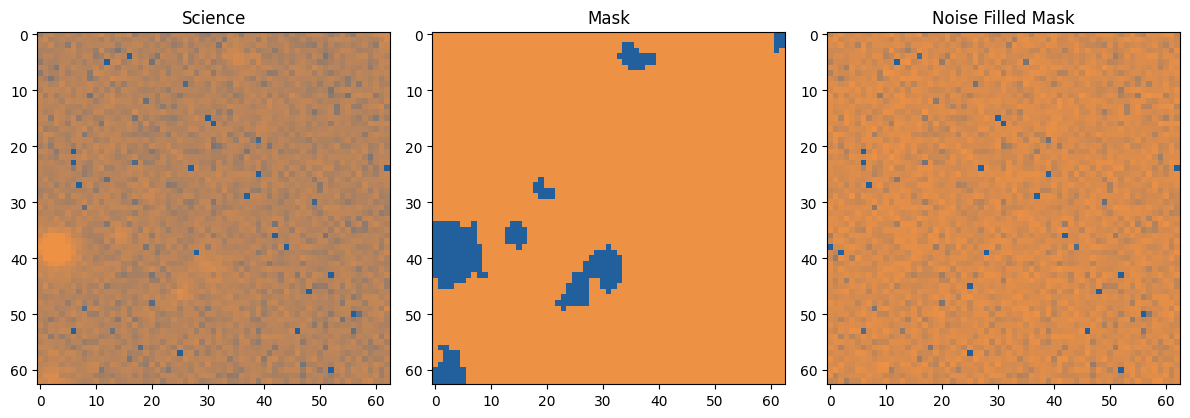

In [98]:
bins=np.logspace(np.log10(min(WD_dist_shuffled_to_shuffled_sci)),
                 np.log10(max(WD_dist_shuffled_to_shuffled_sci)), 50)


# Create subplots to show all 
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
#fig.suptitle(objectID, fontsize=24, y=0.775)

# Show the template image
norm0 = simple_norm(sci_image[0].data, 'log', percent=99.)
ax[0].imshow(sci_image[0].data, norm=norm0, cmap=cmap)
ax[0].set_title('Science')

# Show the SExtractor mask for the template image
mask = sci_seg[0].data == 0
norm1 = simple_norm(np.where(mask, sci_image[0].data, -9999), 'log', percent=99.)
ax[1].imshow(np.where(mask, sci_image[0].data, -9999), norm=norm1, cmap=cmap)
ax[1].set_title('Mask')

# Show the masked template image with the masked locations filled with random noise
mask = sci_seg[0].data > 0
for_filling = np.random.normal(np.median(sci_image[0].data[~mask]), 
                               np.std(sci_image[0].data[~mask]), (63, 63))
for_filling = np.where(mask, for_filling, 0)
to_fill = np.where(mask, 0, sci_image[0].data)
tpl_data = to_fill + for_filling

norm2 = simple_norm(tpl_data, 'log', percent=99.)
ax[2].imshow(tpl_data, norm=norm2,  
             cmap=cmap)
ax[2].set_title('Noise Filled Mask')

fig.tight_layout()
fig.savefig('ZTF18aajwbhh_science.pdf', bbox_inches='tight')

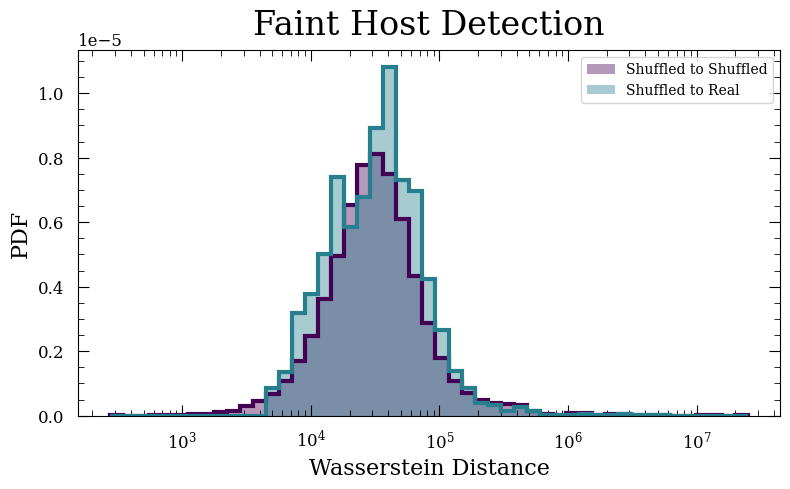

<Figure size 640x480 with 0 Axes>

In [38]:
#bins = np.linspace(min(WD_dist_shuffled_to_shuffled), max(WD_dist_shuffled_to_shuffled), 50)
bins=np.logspace(np.log10(min(WD_dist_shuffled_to_shuffled_sci)),
                 np.log10(max(WD_dist_shuffled_to_shuffled_sci)), 50)

fig, ax = plt.subplots(1,1, figsize=(8, 5))

ax.hist(WD_dist_shuffled_to_shuffled_sci, bins, color='#440154', alpha=0.4, density=True, 
        label='Shuffled to Shuffled');
ax.hist(WD_dist_shuffled_to_shuffled_sci, bins, color='#440154', histtype='step', lw=3, density=True);

ax.hist(WD_dist_real_to_shuffled_sci, bins, color='#277f8e', alpha=0.4, density=True, 
        label='Shuffled to Real');
ax.hist(WD_dist_real_to_shuffled_sci, bins, color='#277f8e', histtype='step', lw=3, density=True);

ax.set_xlabel('Wasserstein Distance')
ax.set_ylabel('PDF')
ax.set_xscale('log')
ax.set_title('Faint Host Detection', fontsize=24, y=1.02)
ax.legend()
fig.tight_layout()
plt.show()
plt.clf()

In [48]:
objectID = 'ZTF22aakkmri'

# Load in the science image and the associated segmentation mask from SExtractor
sci_seg2 = fits.open(f'/media3/CRP7/hosts/data/EXTRAGALACTIC/final_fits/sexoutput/TNS_classified_2year_stamps/output_DETECT_THRESH_1.5__PHOT_APERTURES_5/{objectID}_SCI_0010_SEG.fits')
sci_image2 = fits.open(f'/media3/CRP7/hosts/data/EXTRAGALACTIC/final_fits/sexoutput/TNS_classified_2year_stamps/output_DETECT_THRESH_1.5__PHOT_APERTURES_5/{objectID}_SCI_0010_CAT.fits')

# Load in the template image and the associated segmentation mask from SExtractor
temp_seg2 = fits.open(f'/media3/CRP7/hosts/data/EXTRAGALACTIC/final_fits/sexoutput/TNS_classified_2year_stamps/output_DETECT_THRESH_1.5__PHOT_APERTURES_5/{objectID}_TEMP_0010_SEG.fits')
temp_image2 = fits.open(f'/media3/CRP7/hosts/data/EXTRAGALACTIC/final_fits/sexoutput/TNS_classified_2year_stamps/output_DETECT_THRESH_1.5__PHOT_APERTURES_5/{objectID}_TEMP_0010_CAT.fits')

In [61]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# transfer cutout data
r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': 'ZTF22aakkmri',
    'withcutouts': 'True'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

In [82]:
nalerts = pdf.shape[0]

tem_stamps = pdf['b:cutoutTemplate_stampData'].values
npix = len(tem_stamps[0])

stacked = []
for i in range(npix):
    line = [sum([tem_stamps[k][i][j] for k in range(nalerts)]) for  j in range(npix)]
    stacked.append(line)

stacked = np.array(stacked)

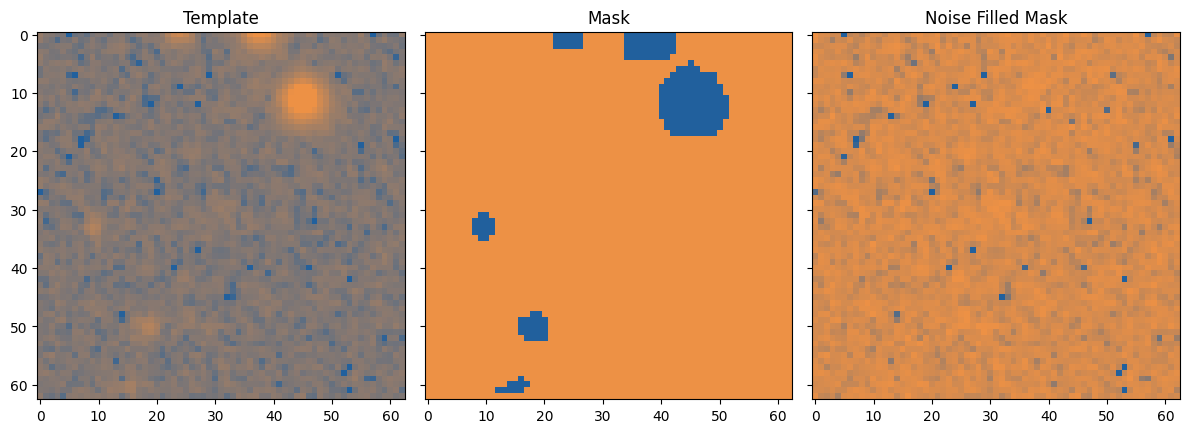

In [97]:
# Create subplots to show all 
fig, ax = plt.subplots(1, 3, figsize=(12, 8), sharex=True, sharey=True)
#fig.suptitle(objectID, fontsize=24, y=0.775)

# Show the template image
norm0 = simple_norm(stacked, 'log', percent=99.)
ax[0].imshow(stacked, norm=norm0, cmap=cmap)
ax[0].set_title('Template')

# Show the SExtractor mask for the template image
mask = temp_seg2[0].data == 0
norm1 = simple_norm(np.where(mask, stacked, -9999), 'log', percent=99.)
ax[1].imshow(np.where(mask, stacked, -9999), norm=norm1, cmap=cmap)
ax[1].set_title('Mask')

# Show the masked template image with the masked locations filled with random noise
mask = temp_seg2[0].data > 0
for_filling = np.random.normal(np.median(stacked[~mask]), 
                               np.std(stacked[~mask]), (63, 63))
for_filling = np.where(mask, for_filling, 0)
to_fill = np.where(mask, 0, stacked)
tpl_data = to_fill + for_filling

norm2 = simple_norm(tpl_data, 'log', percent=99.)
ax[2].imshow(tpl_data, norm=norm2,  
             cmap=cmap)
ax[2].set_title('Noise Filled Mask')

fig.tight_layout()
plt.savefig('ZTF22aakkmri_stamps.pdf', bbox_inches='tight')

In [87]:
real_Abins_dict_sta, shuffled_Abins_dict_sta = \
           ps.detect_host_with_powerspectrum(tpl_image=stacked, 
                                             metric='kstest', N_iter=1000)


N_iter = 1000
size = 7

WD_dist_real_to_shuffled_sta = []
WD_dist_shuffled_to_shuffled_sta = []

for n in range(N_iter):

    iter1 = shuffled_Abins_dict_sta[size][n]
    wd = wasserstein_distance(iter1, real_Abins_dict_sta[size])
    WD_dist_real_to_shuffled_sta.append(wd)

    for m in range(N_iter):
        if m >= n:
            continue
        
        iter2 = shuffled_Abins_dict_sta[size][m]
        wd = wasserstein_distance(iter1, iter2)
        WD_dist_shuffled_to_shuffled_sta.append(wd)

WD_dist_real_to_shuffled_sta = np.array(WD_dist_real_to_shuffled_sta)
WD_dist_shuffled_to_shuffled_sta = np.array(WD_dist_shuffled_to_shuffled_sta)

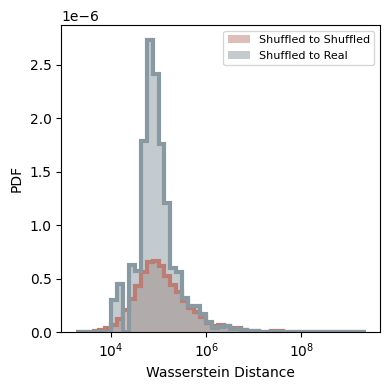

In [102]:
#bins = np.linspace(min(WD_dist_shuffled_to_shuffled), max(WD_dist_shuffled_to_shuffled), 50)
bins=np.logspace(np.log10(min(WD_dist_shuffled_to_shuffled_sta)),
                 np.log10(max(WD_dist_shuffled_to_shuffled_sta)), 50)

fig, ax = plt.subplots(1,1, figsize=(4, 4))

ax.hist(WD_dist_shuffled_to_shuffled_sta, bins, color=colors['rose'], alpha=0.5, density=True, 
        label='Shuffled to Shuffled');
ax.hist(WD_dist_shuffled_to_shuffled_sta, bins, color=colors['rose'], histtype='step', lw=3, density=True);

ax.hist(WD_dist_real_to_shuffled_sta, bins, color=colors['light_gray'], alpha=0.5, density=True, 
        label='Shuffled to Real');
ax.hist(WD_dist_real_to_shuffled_sta, bins, color=colors['light_gray'], histtype='step', lw=3, density=True);

ax.set_xlabel('Wasserstein Distance')
ax.set_ylabel('PDF')
ax.set_xscale('log')
ax.legend(fontsize=8)
fig.tight_layout()
plt.savefig('ZTF22aakkmri_hist.pdf', bbox_inches='tight')
